In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import numpy as np
import pytorch_lightning as pl
import torch
from sklearn.manifold import TSNE

from func2graph import models, data

### Simulated Data

In [5]:
neuron_num = 200
window_size = 200
hidden_size_1 = 32
h_layers_1 = 0
heads = 1
attention_layers = 1
dim_key = 200
to_q_layers = 0
to_k_layers = 0
hidden_size_2 = 64
h_layers_2 = 0
pos_enc_type = "lookup_table"
task_type = "prediction"
predict_window_size = 1
loss_function = "mse"
attention_activation = "none"
scheduler = "cycle"

predict_mode_model = models.Attention_Autoencoder(
    model_random_seed=42,
    neuron_num=neuron_num,
    window_size=window_size,
    hidden_size_1=hidden_size_1,
    h_layers_1=h_layers_1,
    heads=heads,
    attention_layers=attention_layers,
    dim_key=dim_key,
    to_q_layers=to_q_layers,
    to_k_layers=to_k_layers,
    hidden_size_2=hidden_size_2,
    h_layers_2=h_layers_2,
    pos_enc_type=pos_enc_type,
    task_type=task_type,
    predict_window_size=predict_window_size,
    prediction_mode=True,
    loss_function=loss_function,
    attention_activation=attention_activation,
    scheduler=scheduler,
)

checkpoint_path = "../../output/1_16_AA_toy/Attention_Autoencoder_wuwei_200_0.001_0.3_2_5_1.0_1.0_30000_42_cell_type_200_prediction_1_12_32_128_128_0_1_1_200_0_0_64_0_0.0005_lookup_table_spatial_temporal_1_none_cycle_0.0/epoch=999-step=744000.ckpt"

trainer = pl.Trainer(
    devices=[1],
    accelerator="gpu",
    benchmark=False,
    profiler="simple",
)

data_random_seed = 42
weight_type = "cell_type"
batch_size = 32
data_type = "wuwei"

data_result = data.generate_simulation_data(
    neuron_num=neuron_num,
    total_time=30000,
    data_random_seed=data_random_seed,
    weight_type=weight_type,
    window_size=window_size,
    batch_size=batch_size,
    task_type=task_type,
    predict_window_size=predict_window_size,
    data_type=data_type,
)
trainloader, validloader, weight_matrix, cell_type_ids, cell_type2id, cell_type_count = data_result
results = trainer.predict(predict_mode_model, dataloaders=[trainloader], ckpt_path=checkpoint_path)

print(cell_type2id)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


torch.Size([200, 30000])
val_data.shape:  torch.Size([5801, 200, 200])
tensor([[-1.6911,  0.6748,  1.8291,  ...,  0.0242,  0.8528,  2.4147],
        [-1.2896,  1.0702, -0.8654,  ...,  1.6516,  2.1274, -1.5712],
        [-2.0636,  0.4282,  1.8470,  ...,  1.4348, -0.8813, -0.7332],
        ...,
        [-0.2945, -0.9614,  1.7570,  ..., -0.5612,  3.4060,  1.0130],
        [-0.5361, -0.8114,  2.7472,  ..., -0.8744,  0.4353,  1.4764],
        [-0.3347,  0.2065, -1.1262,  ..., -2.0218,  1.5395,  1.5110]])


You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /homes/gws/wz86/func2graph/notebook/check_evaluation/lightning_logs
Restoring states from the checkpoint path at ../../output/1_16_AA_toy/Attention_Autoencoder_wuwei_200_0.001_0.3_2_5_1.0_1.0_30000_42_cell_type_200_prediction_1_12_32_128_128_0_1_1_200_0_0_64_0_0.0005_lookup_table_spatial_temporal_1_none_cycle_0.0/epoch=999-step=744000.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at ../../output/1_16_AA_toy/Attention_Autoencoder_wuwei_200_0.001_0.3_2_5_1.0_1.0_30000_42_cell_type_200_prediction_1_12_32_128_128_0_1_1_200_0_0_64_0_0.0005_lookup_table_spatial_temporal_1

Predicting DataLoader 0:   0%|          | 0/744 [00:00<?, ?it/s]length:  2
1
3
Predicting DataLoader 0:   0%|          | 1/744 [00:00<01:17,  9.61it/s]length:  2
1
3
Predicting DataLoader 0:   0%|          | 2/744 [00:00<00:42, 17.66it/s]length:  2
1
3
Predicting DataLoader 0:   0%|          | 3/744 [00:00<00:29, 25.15it/s]length:  2
1
3
Predicting DataLoader 0:   1%|          | 4/744 [00:00<00:23, 31.73it/s]length:  2
1
3
Predicting DataLoader 0:   1%|          | 5/744 [00:00<00:19, 37.22it/s]length:  2
1
3
Predicting DataLoader 0:   1%|          | 6/744 [00:00<00:17, 42.32it/s]length:  2
1
3
Predicting DataLoader 0:   1%|          | 7/744 [00:00<00:15, 47.16it/s]length:  2
1
3
Predicting DataLoader 0:   1%|          | 8/744 [00:00<00:14, 51.83it/s]length:  2
1
3
Predicting DataLoader 0:   1%|          | 9/744 [00:00<00:13, 55.75it/s]length:  2
1
3
Predicting DataLoader 0:   1%|▏         | 10/744 [00:00<00:12, 59.75it/s]length:  2
1
3
Predicting DataLoader 0:   1%|▏         | 11/744 [

PREDICT Profiler Report

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                      	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                       	|  -              	|  10447          	|  11.726         	

{'EC': 0, 'Pv': 1, 'Sst': 2, 'Vip': 3}


In [6]:
neuron_embeddings = results[0][3]
print(neuron_embeddings.shape)
print(neuron_embeddings[0])

torch.Size([200, 199])
tensor([  1.8961,   0.3732,   6.7178,  10.4606,  -3.9839,  -1.2163, -14.1565,
         -1.5947,  -4.1913, -13.0086,  10.2248,  -9.3886,  -4.7572,   1.9115,
         -4.2106,   1.9018,  -2.3838,  -6.2551,  -8.8595,   3.0375,   0.6742,
          4.8412,   3.2093,   3.5150, -11.1820,  12.2210,   1.5774,  -8.3733,
         -1.8586,  -5.4913,  -3.1786,   0.2865,   7.5831,  -3.6336,   5.2620,
         -8.5192,   3.1485,  -3.5045,  -9.2308,   8.2061,   4.1364,  -3.3127,
         14.6141,  -1.2388,  -1.2132,  -6.0049,  -2.7754,   3.3518,   4.8086,
         -0.9661,  -8.3303,   1.7520,   2.0188,   2.8120,  17.3759,  -0.9465,
        -10.1920,  -2.4602,  -4.4429,   6.8854,   1.5805,  -2.1272,  -0.2121,
         -1.7573, -14.4052,   6.8925,  -3.5057,  -9.2053,   7.4999,   1.1179,
         -3.1930,   6.5929,  -9.2489,  -1.1818,  -5.5777,  -3.2526,   9.6675,
         -0.8205,   1.5855,  -1.7652,  -5.8662,  -2.4464,  -2.7265,  -1.8216,
          0.9887,  -4.1789, -19.9484,  -6

In [20]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=15).fit_transform(neuron_embeddings)
print(tsne.shape)

(200, 2)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


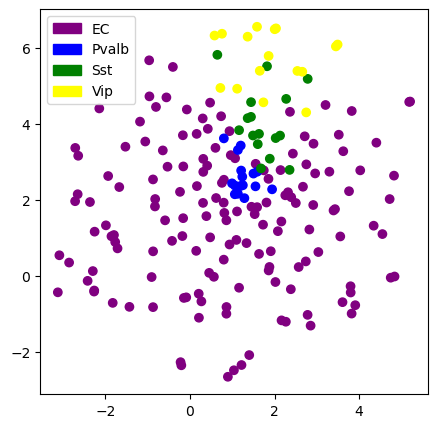

In [21]:
# color by cell type
print(cell_type_ids)

colors = ['purple', 'blue', 'green', 'yellow']
colors_list = [colors[i] for i in cell_type_ids]

plt.figure(figsize=(5, 5))
# create a legend to map cell type to color
plt.scatter(tsne[:, 0], tsne[:, 1], c=colors_list)
purple_patch = mpatches.Patch(color='purple', label='EC')
blue_patch = mpatches.Patch(color='blue', label='Pvalb')
green_patch = mpatches.Patch(color='green', label='Sst')
yellow_patch = mpatches.Patch(color='yellow', label='Vip')
plt.legend(handles=[purple_patch, blue_patch, green_patch, yellow_patch])
plt.show()

In [15]:
# get all activity
activity = []

for batch in trainloader:
    activity.append(batch[0].cpu().numpy())

activity = np.concatenate(activity, axis=0)
print(activity.shape)

# get all activity for each cell
activity_cell = []
for i in range(neuron_num):
    activity_cell.append(activity[:, i, :].reshape(-1))
activity_cell = np.array(activity_cell)
print(activity_cell.shape)

(23801, 200, 199)
(200, 4736399)


(200, 2)


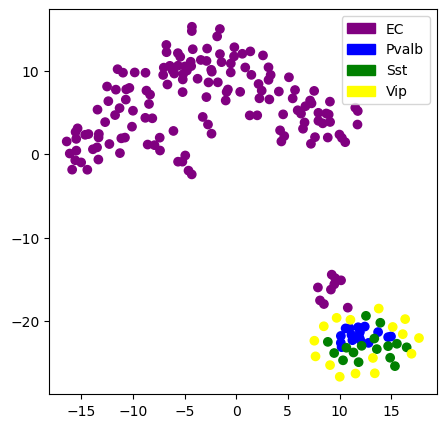

In [16]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=15).fit_transform(activity_cell)
print(tsne.shape)

plt.figure(figsize=(5, 5))
plt.scatter(tsne[:, 0], tsne[:, 1], c=colors_list)
purple_patch = mpatches.Patch(color='purple', label='EC')
blue_patch = mpatches.Patch(color='blue', label='Pvalb')
green_patch = mpatches.Patch(color='green', label='Sst')
yellow_patch = mpatches.Patch(color='yellow', label='Vip')
plt.legend(handles=[purple_patch, blue_patch, green_patch, yellow_patch])
plt.show()

### Real Mouse Data

In [3]:
window_size = 200
batch_size = 32
predict_window_size = 1
dim_key = 200
hidden_size_2 = 128
h_layers_2=0
attention_activation="none"

train_dataloader, val_dataloader, num_unqiue_neurons, cell_type_order, all_sessions_new_cell_type_id, num_batch_per_session_TRAIN, num_batch_per_session_VAL, sessions_2_original_cell_type, neuron_id_2_cell_type_id = data.generate_mouse_all_sessions_data(
    window_size=window_size,
    batch_size=batch_size,
    normalization="session",
)

single_model = models.Attention_With_Constraint(
    num_unqiue_neurons=num_unqiue_neurons,
    num_cell_types=len(cell_type_order),
    window_size=window_size,
    predict_window_size=predict_window_size,
    heads=1,
    attention_layers=1,
    dim_key=dim_key,
    hidden_size_2=hidden_size_2,
    h_layers_2=h_layers_2,
    attention_activation=attention_activation,
)

checkpoint_path = "../../output/1_11_AwC/Attention_With_Constraint_32_200_1_session_42_128_2_1_1_200_128_0_0.2_0.001_mse_0.0_none_cycle_0.0_0.04/epoch=6-step=3479.ckpt"
trained_model = single_model.load_from_checkpoint(checkpoint_path)
trained_model.eval()

indices = torch.tensor([0,1,2]).cuda()
neuron_embeddings = trained_model.embedding_table(indices)
print(neuron_embeddings.shape)

cell_type_order: ['EC', 'IN', 'Lamp5', 'Pvalb', 'Serpinf1', 'Sncg', 'Sst', 'Vip']


RuntimeError: Error(s) in loading state_dict for Attention_With_Constraint:
	Missing key(s) in state_dict: "attentionlayers.0.0.to_q_fc_layers.0.2.weight", "attentionlayers.0.0.to_q_fc_layers.0.2.bias", "attentionlayers.0.0.to_q_fc_layers.1.2.weight", "attentionlayers.0.0.to_q_fc_layers.1.2.bias", "attentionlayers.0.0.to_k_fc_layers.0.2.weight", "attentionlayers.0.0.to_k_fc_layers.0.2.bias", "attentionlayers.0.0.to_k_fc_layers.1.2.weight", "attentionlayers.0.0.to_k_fc_layers.1.2.bias". 
	Unexpected key(s) in state_dict: "attentionlayers.0.0.to_q_fc_layers.0.0.weight", "attentionlayers.0.0.to_q_fc_layers.0.0.bias", "attentionlayers.0.0.to_q_fc_layers.1.0.weight", "attentionlayers.0.0.to_q_fc_layers.1.0.bias", "attentionlayers.0.0.to_k_fc_layers.0.0.weight", "attentionlayers.0.0.to_k_fc_layers.0.0.bias", "attentionlayers.0.0.to_k_fc_layers.1.0.weight", "attentionlayers.0.0.to_k_fc_layers.1.0.bias". 

In [4]:
# create a tensor from 0 to num_unqiue_neurons
indices = torch.arange(num_unqiue_neurons).cuda()
neuron_embeddings = trained_model.embedding_table(indices)
print(neuron_embeddings.shape)

print(neuron_id_2_cell_type_id)
print('unique cell type ids', np.unique(neuron_id_2_cell_type_id))

torch.Size([1616, 199])
[6. 7. 2. ... 0. 1. 0.]
unique cell type ids [0. 1. 2. 3. 4. 5. 6. 7.]


In [5]:
print(neuron_embeddings.detach().cpu().numpy())

[[ 1.3073022   0.82383496  2.13942    ... -2.0367012   0.583211
  -0.20767944]
 [ 0.48835292 -1.660845    0.08040127 ...  0.1926914   0.24354853
  -0.34806105]
 [-1.557687    1.0430316   1.0810841  ... -0.34745717 -1.8649477
   0.04671832]
 ...
 [-0.71394527  0.57698613 -0.2678873  ...  0.6629255   0.55943334
  -1.0659844 ]
 [-1.1968794   0.57375425 -0.4461169  ...  0.07045463  0.78093755
  -0.5062239 ]
 [-0.40524524 -1.1208308   0.87030274 ... -0.08694222 -0.50549704
   1.3670311 ]]


### Binary Classification

In [6]:
from sklearn.linear_model import LogisticRegression
# randomly split the data into train and test
train_indices = np.random.choice(len(neuron_id_2_cell_type_id), int(len(neuron_id_2_cell_type_id) * 0.8), replace=False)
test_indices = np.setdiff1d(np.arange(len(neuron_id_2_cell_type_id)), train_indices)

ec_in_neuron_id_2_cell_type_id = neuron_id_2_cell_type_id.copy()
ec_in_neuron_id_2_cell_type_id[ec_in_neuron_id_2_cell_type_id != 0] = 1

all_X = neuron_embeddings.detach().cpu().numpy()
all_y = ec_in_neuron_id_2_cell_type_id

X_train = neuron_embeddings.detach().cpu().numpy()[train_indices]
y_train = ec_in_neuron_id_2_cell_type_id[train_indices]
X_test = neuron_embeddings.detach().cpu().numpy()[test_indices]
y_test = ec_in_neuron_id_2_cell_type_id[test_indices]


In [60]:
# TSNE

tsne = TSNE(n_components=4, learning_rate='auto', init='random', perplexity=15, method='exact').fit_transform(all_X)
print(tsne.shape)

(1616, 4)


In [ ]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(neuron_embeddings.detach().cpu().numpy())
embedding.shape

In [62]:
# KNN

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(tsne[train_indices], y_train)
y_pred = knn.predict(tsne[test_indices])
print(accuracy_score(y_test, y_pred))

0.5216049382716049


In [56]:
# K means clustering

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto').fit(tsne)
print(kmeans.labels_)
print(y)
print('accuracy', np.sum(kmeans.labels_ == y) / len(y))

[1 1 0 ... 0 1 1]
[1. 0. 1. ... 0. 0. 0.]
accuracy 0.5123839009287926


In [7]:

clf = LogisticRegression(random_state=42).fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(np.unique(y_train, return_counts=True)[1] / len(y_train))

print(clf.score(X_test, y_test))
print(np.unique(y_test, return_counts=True)[1] / len(y_test))

0.6787925696594427
[0.57120743 0.42879257]
0.595679012345679
[0.53395062 0.46604938]


In [35]:
clf = LogisticRegression(random_state=42).fit(X, y)
print(clf.score(X, y))
print(np.unique(y, return_counts=True)[1] / len(y))

X_test = neuron_embeddings.detach().cpu().numpy()[test_indices]
y_test = ec_in_neuron_id_2_cell_type_id[test_indices]
print(clf.score(X_test, y_test))
print(np.unique(y_test, return_counts=True)[1] / len(y_test))

0.7043343653250774
[0.56114551 0.43885449]
0.5771604938271605
[0.57407407 0.42592593]


In [96]:
# 把不同class的label都改成从0开始！！

all_X = neuron_embeddings.detach().cpu().numpy()[((neuron_id_2_cell_type_id != 0) & (neuron_id_2_cell_type_id != 1) & (neuron_id_2_cell_type_id != 4) & (neuron_id_2_cell_type_id != 5) & (neuron_id_2_cell_type_id != 6))]
all_y = neuron_id_2_cell_type_id[((neuron_id_2_cell_type_id != 0) & (neuron_id_2_cell_type_id != 1) & (neuron_id_2_cell_type_id != 4) & (neuron_id_2_cell_type_id != 5) & (neuron_id_2_cell_type_id != 6))]


train_indices = np.random.choice(len(all_y), int(len(all_y) * 0.8), replace=False)
test_indices = np.setdiff1d(np.arange(len(all_y)), train_indices)

X_train = all_X[train_indices]
y_train = all_y[train_indices]
X_test = all_X[test_indices]
y_test = all_y[test_indices]

clf = LogisticRegression(random_state=42, max_iter=100, penalty='l1', solver='liblinear').fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(np.unique(y_train, return_counts=True)[1] / len(y_train))
y_train_pred = clf.predict(X_train)

for i in range(2, len(cell_type_order)):
    print(i, np.sum(y_train_pred[y_test == i] == i) / np.sum(y_test == i))

print(clf.score(X_test, y_test))
print(np.unique(y_test, return_counts=True)[1] / len(y_test))
y_test_pred = clf.predict(X_test)

# accuracy for each label
for i in range(2, len(cell_type_order)):
    print(i, np.sum(y_test_pred[y_test == i] == i) / np.sum(y_test == i))

1.0
[0.38812785 0.26484018 0.34703196]
0.36363636363636365
[0.41818182 0.29090909 0.29090909]
2 0.43478260869565216
3 0.3125
4 nan
5 nan
6 nan
7 0.3125


/tmp/ipykernel_1562069/844666720.py:23: RuntimeWarning:

invalid value encountered in scalar divide

